***
# Lab 2 - Deploy Retrieval-Augmented Generation (RAG) on OpenShift on IBM Power10
(This lab is part of [AI on Power - Level 3 course](https://ibm.github.io/AI-on-Power-Level3/))
***
Author(s): Marvin Gießing (marving@de.ibm.com) & Deepak C Shetty (deepakcshetty@in.ibm.com)<br>
_(Originally authored by Marvin and adapted by Deepak to suit TechZone's OpenShift on Power10 env. for Level 3 course)_
***

## How to use jupyter notebook - Quick guide
* Notebook consists of cells. You can type code or text in each cell.

* There are mainly 2 types of cells:
    * **Code cell**: Contains code to be executed. When the code is run, the notebook displays the output below the code cell that generated it.
    * **Markdown cell**: Contains text formatted using Markdown and displays its output in-place when the Markdown cell is run.
<br>
<br>
* To **execute** any cell, select it and press `Shift+Enter` on the keyboard or click the `Run` button (single arrow icon) in the toolbar present in the top of this notebook.
    * You will see \[\*\] on the top left corner of the cell while the code cell is being executed and it will switch to a number (e.g.: \[45\]) after the execution finishes. When navigating through code cells, wait for the code cell to finish execution completely before moving to next cell.
<br>
<br>
* To **edit** any cell, select it and press `Enter` on the keyboard or `double-click` the cell using the mouse.

***

## Clear all outputs

Before we start the lab, let's start with a clean slate.<br>
Click on **Edit** and select **Clear All outputs** to clear all the outputs of all the cells in this NB.
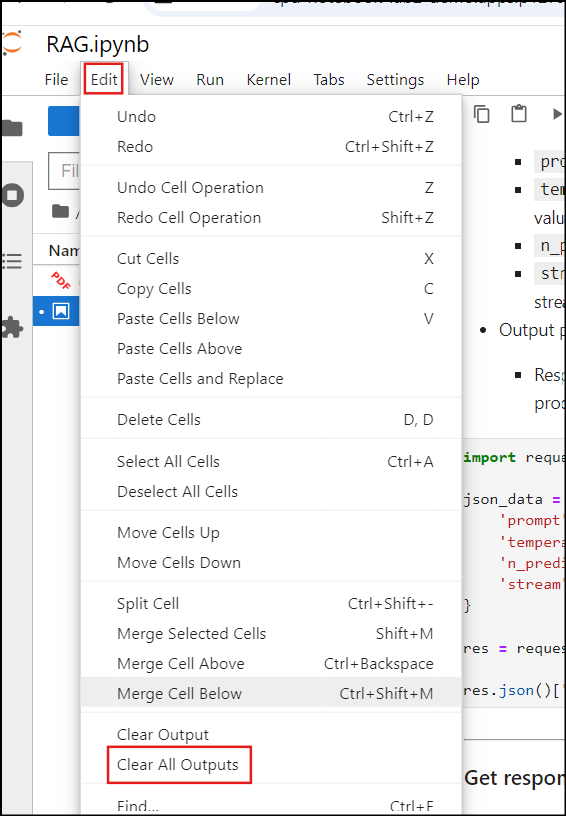

## Respond to natural language questions using RAG approach

This notebook contains the steps and code to demonstrate support of Retrieval Augumented Generation using a local model deployed on Power10. It introduces commands for data retrieval, knowledge base building & querying, and model testing.

Some familiarity with Python is helpful. This notebook uses Python 3.10.

### About Retrieval Augmented Generation
Retrieval Augmented Generation (RAG) is a versatile pattern that can unlock a number of use cases requiring factual recall of information, such as querying a knowledge base in natural language.

In its simplest form, RAG requires 3 steps:

- Phase 1: Index knowledge base passages (once)
- Phase 2: Retrieve relevant passage(s) from knowledge base (for every user query)
- Phase 3: Generate a response by feeding retrieved passage into a large language model (for every user query)

***

### Setup environment variables

Let's setup environment variables to hold milvus DB and LLM's hostname and port

- MILVUS_HOST & MILVUS_PORT will point to the OpenShift service serving milvus DB's hostname and port respectively
- LLAMA_HOST & LLAMA_PORT will point to the OpenShift service serving granite model's hostname and port respectively

<div class="alert alert-block alert-info">
    
* For MILVUS_HOST, using `milvus-service` as the hostname works as this jupyter lab is in the same OpenShift project as milvus DB.<br>

* For LLAMA_HOST, since the granite LLM is deployed in a different project (lab1-demo), we need to use the fully qualified hostname of the associated service (lab1-service) in order for this notebook to reach the LLM.
    
</div>

<div class="alert alert-block alert-warning">
    
**IMP**: The below provided environment variables will work if you have followed Lab1 as-is.<br>
In case you used a different OpenShift project name and/or OpenShift service name for Lab1 - please navigate to your Lab1's OpenShift service and copy the fully qualified hostname of the service and paste it against the LLAMA_HOST environment variable.

- In OpenShift **Adminstrator** profile console window, select **Networking** -> **Services**, click on your service (lab1-service in my case) and copy the `Hostname`

</div>


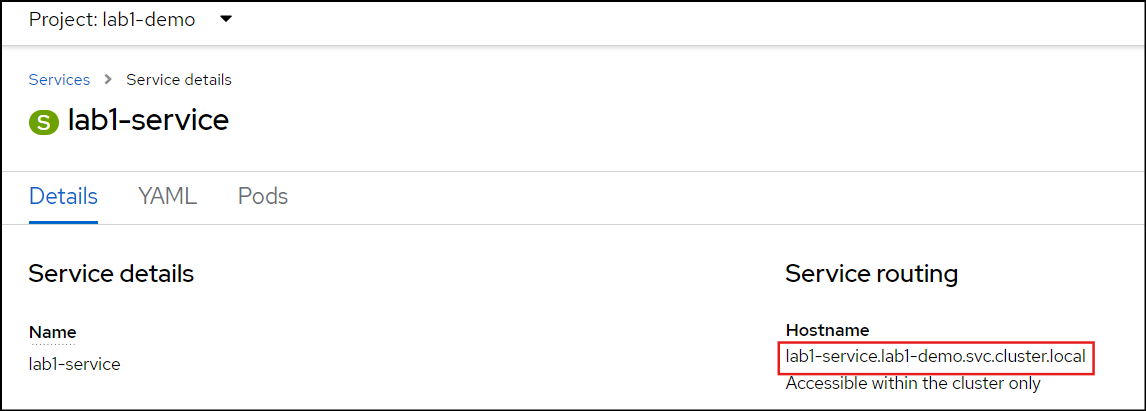

In [ ]:
MILVUS_HOST="milvus-service"
MILVUS_PORT="19530"

LLAMA_HOST="lab1-service.lab1-demo.svc.cluster.local"
LLAMA_PORT="8080"

***

### Clean up milvus DB

Connect to the milvus DB, delete any existing collections (possible if you are re-doing this step) to get a clean start!

What does the below code do:

 - Uses connections module of pymilvus python package to connect to the DB
 - Prints the existing collections, if any
 - Deletes all the collections to get a clean start

In [ ]:
from pymilvus import connections, utility

# Connect to Milvus Database
connections.connect(host="milvus-service", port="19530")

colls = utility.list_collections()
print(colls)

for coll in colls:
    utility.drop_collection(coll)

***

### Phase 1: Ingesting data & build up knowledge base

![image](https://github.com/dpkshetty/watsonx-rag/blob/main/images/Ingest_Data.png?raw=true)

***

Let's download a sample PDF file.<br>
I have selected [this](https://www.ibm.com/downloads/cas/YE3OVQNB) PDF which is a whitepaper and a public reference win story for GenAI on IBM Power10.

**IMP**: If you wish to download a different PDF, please make sure the PDF is not too big in size.<br>
Remember this is a demo and a constrained environment in terms of memory and storage resources.

In [ ]:
import requests
import os
FNAME = "opentech-solution-wp.pdf"

if not os.path.exists(FNAME):
    res = requests.get('https://www.ibm.com/downloads/cas/YE3OVQNB')
    with open(FNAME, 'wb') as file:
        file.write(res.content)

***

Now let's store the downloaded PDF into the milvus vector DB.

The code snippet below does the following:

 - Splits the PDF into smaller document chunks. 
     - This is done to improve vector search efficiency, reduce memory and computational resources, improve retrieval and ranking and embedding smaller chunks ensures that the context within that chunk is preserved
<br>
 - Instantiate an embeddings model from HF. 
     - Embedding models are widely used in natural language processing (NLP), computer vision, and recommendation systems to convert data (like words, sentences, images, or items) into dense vector representations.
<br>
 - Use the embeddings model to create a vector store in milvus. Here's a breakdown of the key parameters:
     - `docs`: The documents (split text) you want to store in the vector database. These are typically split at the sentence or paragraph level, as discussed earlier.
     - `embedding=embeddings`: You pass the embeddings generated by the Hugging Face model to store the vector representations of the documents.
     - `collection_name="demo"`: This specifies the name of the collection where the document vectors will be stored in Milvus.
     - `connection_args={"host": MILVUS_HOST, "port": MILVUS_PORT}`: This defines the connection settings to the Milvus server, specifying the host and port.

In [ ]:
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import Milvus
from langchain.document_loaders import WebBaseLoader, PyPDFLoader
from langchain.text_splitter import CharacterTextSplitter

# Splits the PDF into smaller document chunks

loader = PyPDFLoader(FNAME)
docs = loader.load()

text_splitter = CharacterTextSplitter(separator="\n", chunk_size=768, chunk_overlap=0)
docs = text_splitter.split_documents(docs)

# Instantiate an embeddings model from HF

embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

# Use the embeddings model to create a vector store in milvus

vector_store = Milvus.from_documents(
    docs,
    embedding=embeddings,
    collection_name="demo",
    connection_args={"host": MILVUS_HOST, "port": MILVUS_PORT}
)

# List the collections to confirm the the 'demo' collection was indeed created

utility.list_collections()

***

### Phase 2: Retrieve relevant passage(s) from Knowledge Base

![image](https://github.com/mgiessing/watsonx-rag/blob/main/images/Retrieve_Data.png?raw=true)

***

Next, given a question, let's do a similarity search and retrieve the relevant documents from milvus DB

The code snippet below does the following:
- `vector_store.similarity_search_with_score()`: This method queries the Milvus vector database for documents that are similar to the input question. It uses the embeddings stored in the vector database to compute the similarity scores between the query embedding (generated from question) and the embeddings of the stored documents.
    - Parameters:
        - `question`: The input text (or query) that will be converted into an embedding and compared to the document vectors in the vector store.
        - `k=3`: The number of top results you want to retrieve. In this case, it will return the top 3 documents that are most similar to the query.
    - Returns:
        - `docs`: This variable will store the results, which include both the documents and their corresponding similarity scores. The documents are sorted by their similarity scores in descending order, with the most similar document first.

In [ ]:
# Question to ask
question = "Describe the problem faced by opentech and the solution proposed by IBM"

# Get relevant documents using similarity search
docs = vector_store.similarity_search_with_score(question, k=3)

***

### Phase 3: Build prompt, pass to LLM & generate response

![image](https://github.com/mgiessing/watsonx-rag/blob/main/images/Generate_Response.png?raw=true)

***

To generate a response from LLM we need to form a query which consists of "Prompt + Question".<br>
The `build_prompt` function in the code snippet below, does exactly that.<br>
This function constructs a prompt for generating a short, concise answer based on a query and retrieved document chunks.<br>

Here's a detailed explanation:
- Input Parameters:
    - `question`: The user's query or question that you are trying to answer.
    - `topn_chunks: list[str]`: A list of document chunks retrieved from a vector database (e.g., Milvus), where each chunk contains both the document content and metadata like the page number.
- Prompt Construction:
    - `Instructions Section`: The prompt starts by providing clear instructions. This guides the model to focus on crafting a single, short, and relevant sentence.
    - `Adding Search Results`: The search results (document chunks) are formatted and appended to the prompt.
    - For each chunk:
        - Metadata: It includes the page number extracted from the chunk’s metadata to provide context to the model (e.g., `[Page 12]`)
        - Text Content: The `page_content` from each chunk is added to the prompt after removing any newlines, converting it into a single-line string.
    - `Query Section`: After adding the search results, the prompt includes the query. This sets up the task for the model to generate the final answer.
<br>
- Final Prompt: The constructed prompt will look something like this:
```
Instructions: Compose a single, short sentence that only answers the query, using the provided search results. If the search results do not mention anything say 'Found nothing.'

Search results:
[Page 1]: << Relevant Text from Page 1 >>
[Page 3]: << Relevant Text from Page 3 >>
[Page 5]: << Relevant Text from Page 5 >>

Query: << User's question >>

Answer:
```

In [ ]:
def build_prompt(question, topn_chunks: list[str]):
    prompt = "Instructions: Compose a single, short sentence that only answers the query, using the provided search results."\
             "If the search results do not mention anything say 'Found nothing.'\n\n"
  
    prompt += "Search results:\n"
    for chunk in topn_chunks:
        prompt += f"[Page {chunk[0].metadata['page']}]: " + chunk[0].page_content.replace("\n", " ") + "\n\n"

    prompt += f"Query: {question}\n\nAnswer: "

    return prompt

***

The code snippet below invokes the `build_prompt` function and prints the prompt that is generated.<br>

As expected, the prompt has the instructions, the search results and the user's question included.

In [ ]:
prompt = build_prompt(question, docs)
print(prompt)

***

Let's send our prompt to the granite model and check the response.
<br>
Large Language Models (LLMs) can operate in two main modes when generating responses: batch mode and streaming mode.<br>
Both modes are useful in different contexts, depending on the use case and the constraints of the system in which they are deployed.
<br>

- Batch Mode
    - In batch mode, the input data is processed in chunks (or batches), and the model generates the output for each batch at once. This is often the preferred mode when dealing with high-throughput applications where you need to process multiple inputs simultaneously.

- Streaming Mode
    - In streaming mode, the model generates output token by token (or in smaller chunks), and the output is sent to the client as it is being produced. This is useful for real-time applications, where immediate feedback or partial results are desired.

#### Get response from LLM - Batch mode

The code snippet below sends a HTTP POST request to the AI model (Granite in our case) to generate text completion based on the provided prompt.
<br>
- Input parameters:
    - `prompt`: This is the text input you provide to the model, asking it to complete or generate a response based on it.
    - `temperature`: This controls the level of randomness in the output. A value closer to 0 (e.g., 0.1) makes the output more deterministic and focused, while higher values (closer to 1) allow for more creative and random outputs.
    - `n_predict`: Specifies the number of tokens (words or characters) that the model should generate in response to the prompt.
    - `stream`: Setting stream=False means the model will operate in batch mode (i.e., it will generate the entire response at once). If set to True, the model will work in streaming mode, where it sends partial responses as they are generated.
    
- Output parameters
    - Response: The response is in JSON format. Using `res.json()['content']`, you extract the generated text content from the response and can display or further process it.

In [ ]:
import requests

json_data = {
    'prompt': prompt,
    'temperature': 0.1,
    'n_predict': 200,
    'stream': False,
}

res = requests.post(f'http://{LLAMA_HOST}:{LLAMA_PORT}/completion', json=json_data)

res.json()['content']

***

#### Get response from LLM - Streaming mode

The code snippet below uses `httpx` python package for asynchronous streaming of responses from LLM (Granite model in our case).
<br>

Here are the key components and how they work:
- `httpx.AsyncClient`:
    - This is an asynchronous HTTP client, which allows you to make non-blocking requests. The `timeout=60` is set to allow the model more time for processing long inputs, as generating 200 tokens might take longer.
- `client.stream`:
    - This sends a `POST` request to the AI model, streaming the response back to the client in real-time. The `stream=True` flag in the `json_data` ensures that the AI model will return results token-by-token or in smaller chunks rather than all at once.
- Streaming the Response:
    - The response is streamed asynchronously using `aiter_bytes()`, which iterates over the raw byte chunks as they are sent back by the AI model.
- Decoding the Chunks:
    - Each chunk is decoded from UTF-8 and adjusted by skipping the first 6 characters `(chunk.decode('utf-8')[6:])`. This is likely because the chunk contains a header or metadata at the start, which is being skipped.
- Checking for Completion:
    - The `data['stop']` flag checks whether the server has finished generating the response. If `False`, the model is still generating content. If `True`, the content generation has ended, and additional metadata, like timing information, is printed.

The timing data printed are the performance metrics from the AI model during a prediction task. Here is a breakdown of what each metric is:
- `prompt_n`: This represents the number of tokens in the input prompt that the model processed.
- `prompt_ms`: This indicates the total time in milliseconds the model took to process the prompt.
- `prompt_per_token_ms`: This is the average time in milliseconds the model took to process each token in the prompt.
- `prompt_per_second`: This value indicates the model's token processing speed (tokens per second).
- `predicted_n`: This represents the number of tokens generated in the output or prediction.
- `predicted_ms`: This is the total time taken to generate the prediction.
- `predicted_per_token_ms`: This indicates the model's token prediction time (milliseconds per token).
- `predicted_per_second`: The indicates the model's number of tokens predicted per second model.


In [ ]:
import httpx
import json

json_data = {
    'prompt': prompt,
    'temperature': 0.1,
    'n_predict': 200,
    'stream': True,
}

client = httpx.AsyncClient(timeout=60) #set higher timeout, because long prompt evaluation might take longer
lastChunks = ""
async with client.stream('POST', f'http://{LLAMA_HOST}:{LLAMA_PORT}/completion', json=json_data) as response:
    async for chunk in response.aiter_bytes():
        try:
            data = json.loads(chunk.decode('utf-8')[6:])
        except:
            pass
        if data['stop'] is False:
            print(data['content'], end="")
        else:
            print('\n\n')
            print(data['timings'])

***

#### Try different questions

Make sure you read the PDF (IBM whitepaper) we used in this lab so that you can ask relevant questions to test the LLM and verify the accuracy of the response.

- Go back to the code cell (scroll up) where we had set the question.
- Edit the code cell, change the question to something different of your choice and execute the code cell.
- Execute all the cells from there onwards (thus following the RAG process of doing a similarity search, generating prompt and feeding LLM with prompt) to get the response to your new question.

Repeat this process for any new question you may have.<br>
Happy learning!

***

### (Optional) exercises if you finish early :)

In order to get better results you have a few options to try out:
- Experiment with the parameters (e.g. temperature, top-k, top-p, n_predict )
- Experiment with the prompt/instruction
- Try out a different model (make sure to use a pre-converted `.gguf` model)
- Load a different PDF but make sure the PDF isn't too big as this is a demo/constrained environment in terms of memory and storage resources!